In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
import sys
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
import plotly.graph_objects as go

In [ ]:
def check_endianness(filename):
  f=open(filename,'rb')
  #little endian
  version=np.fromfile(f,np.int32,count=1)[0]
  endian='l'
  if abs(version) > 100:
    f.close()
    f=open(filename,'rb')
    version=np.fromfile(f,'>i4',count=1)[0]
    endian='B'
  access='st'
  f.close()
  return version,endian,access

def read_stream(filename,endian):
  f=open(filename,'rb')
  fmt='>i4'
  version=np.fromfile(f,np.int32,count=1)[0]
  fmt='>S64'
  runID=np.fromfile(f, fmt, count=1)[0]
  time=np.fromfile(f,np.float32,count=1)[0]
  if version>13:
    ra,pr,axi,sc,ek,stef,prmag,radratio,sigma=np.fromfile(f,np.float32,count=9)
  else:
    ra,pr,axi,sc,ek,prmag,radratio,sigma=np.fromfile(f,np.float32,count=8)
    stef=0.0
  fmt='>i4'
  nr,ntheta,npi,minc,n_r_ic_max=np.fromfile(f,np.int32,count=5)
  if npi==2*ntheta:
    npi=int(npi/minc)
  nphi=npi*minc+1

  if version>13:
    l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=6)
  else:
    l_heat,l_chem,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=5)
    l_phase=False
  colatitude=np.fromfile(f,np.float32,ntheta)
  radius=np.fromfile(f,np.float32,nr)
  if(l_mag!=0 and n_r_ic_max>1):
    radius_ic=np.fromfile(f,np.float32,n_r_ic_max)

  vr=np.zeros((npi,ntheta,nr),np.float32)
  vtheta=np.zeros_like(vr)
  vphi=np.zeros_like(vr)
  if l_heat!=0:
    entropy=np.zeros_like(vr)
  if l_press!=0:
    pre=np.zeros_like(vr)


    #outer core
  for i in range(nr):
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vr[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vtheta[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vphi[:,:,i]=dat.reshape(npi,ntheta)
    if l_heat!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      entropy[:,:,i]=dat.reshape(npi,ntheta)
    if l_press!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      pre[:,:,i]=dat.reshape(npi,ntheta)
  radius_rev=radius[...,::-1]
  vr_rev=vr[...,::-1]
  vtheta_rev=vtheta[...,::-1]
  vphi_rev=vphi[...,::-1]
  entropy_rev=entropy[...,::-1]
  radius_rev=radius[::-1]

  f.close()
  #list_1=[version,runID]
  #list_2=[time,ra,pr,axi,sc,ek,stef,prmag,radratio,sigma]
  #list_3=[nr,ntheta,nphi,minc,n_r_ic_max]
  #list_4=[l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic]
  #list_5=[colatitude,radius]
  list_geo=[radius_rev,nphi,ntheta,nr]
  list_vel=[vr_rev,vtheta_rev,vphi_rev,entropy_rev]
  #list_6=[entropy,pre]
  return list_vel,list_geo,minc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_equatorial(data, radius, minc=2, cmap='jet', levels=50, pcolor=False, cbar=True):
    nphi,nr=data.shape
    phi = np.linspace(0, 2 * np.pi / minc if minc > 1 else 2 * np.pi, nphi)
    rr, pphi = np.meshgrid(radius, phi)
    xx, yy = rr * np.cos(pphi), rr * np.sin(pphi)
    vmax=np.max(np.abs(data))
    norm=mcolors.TwoSlopeNorm(vmin=-vmax,vcenter=0,vmax=vmax)
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_func = ax.pcolormesh if pcolor else ax.contourf
    im = plot_func(xx, yy, data, levels=levels, cmap=cmap,norm=norm)
    if cbar:
        plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()
    return fig
def plot_meridional(data,radius,minc=2,cmap='jet',levels=50,pcolor=False,cbar=True):
  ntheta,nr=data.shape
  th=np.linspace(0,np.pi,ntheta)
  rr,tth=np.meshgrid(radius,th)
  xx,yy=rr*np.sin(tth),rr*np.cos(tth)
  vmax=np.max(np.abs(data))
  norm=mcolors.TwoSlopeNorm(vmin=-vmax,vcenter=0,vmax=vmax)
  fig,ax=plt.subplots(figsize=(6,6))
  plot_func=ax.pcolormesh if pcolor else ax.contourf
  im=plot_func(xx, yy, data, levels=levels, cmap=cmap,norm=norm)
  if cbar:
    plt.colorbar(im, ax=ax)
  ax.set_aspect('equal')
  ax.axis('off')
  plt.show()
  return fig

In [ ]:
version,endian,access=check_endianness('G_100.test_BIS')
list_vel,list_geo,minc=read_stream('G_100.test_BIS',endian)

In [ ]:
vr,vtheta,vphi=list_vel[0],list_vel[1],list_vel[2]
nlon,nlat,nr=vr.shape[0],vr.shape[1],vr.shape[2]
lon=np.linspace(0,np.pi/3,nlon)
lat=np.linspace(0,np.pi,nlat)
theta_grid,phi_grid=np.meshgrid(lon,lat,indexing='ij')
vphi_outer=vphi[:,:,-1]
vtheta_outer=vtheta[:,:,-1]
vr_outer=vr[:,:,-1]

vphi_inner=vphi[:,:,0]
vtheta_inner=vtheta[:,:,0]
vr_inner=vr[:,:,0]

(48, 144) (48, 144) (48, 144)


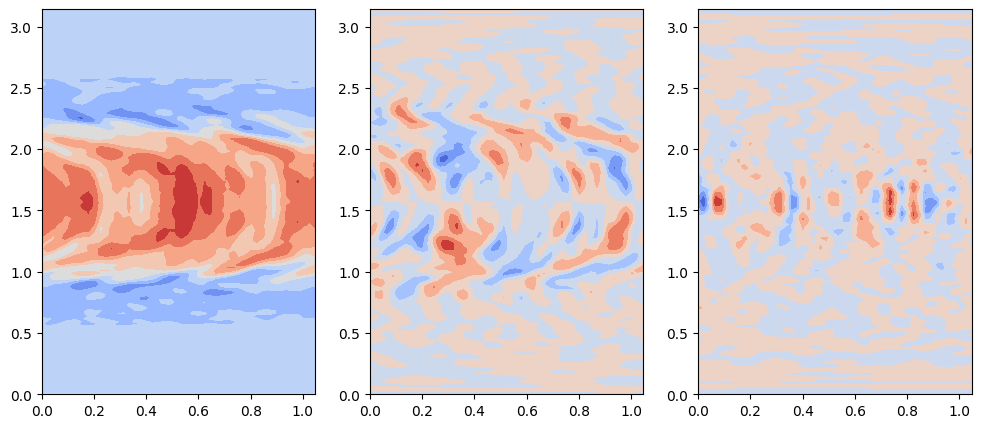

In [ ]:
print(theta_grid.shape,phi_grid.shape,vphi_outer.shape)
fig,axes=plt.subplots(1,3,figsize=(12,5))
axes[0].contourf(theta_grid,phi_grid,vphi_outer,cmap='coolwarm')
axes[1].contourf(theta_grid,phi_grid,vtheta_outer,cmap='coolwarm')
axes[2].contourf(theta_grid,phi_grid,vr_outer,cmap='coolwarm')

(48, 144) (48, 144) (48, 144)


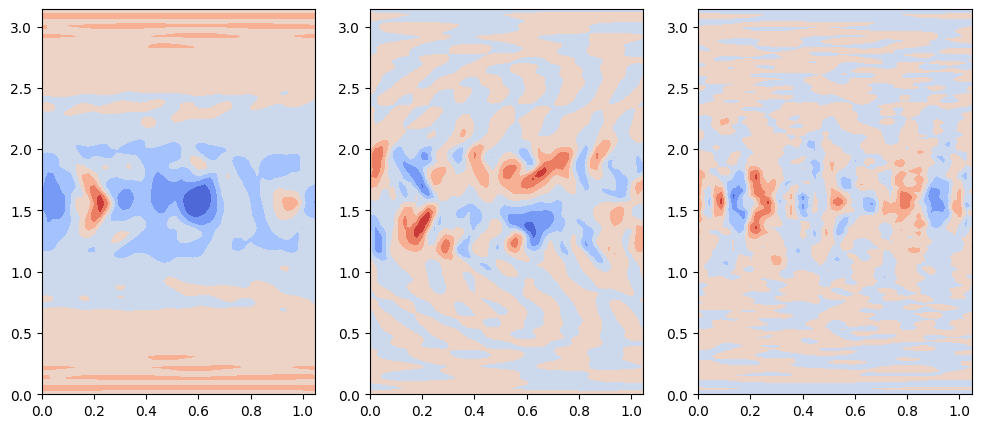

In [ ]:
print(theta_grid.shape,phi_grid.shape,vphi_outer.shape)
fig,axes=plt.subplots(1,3,figsize=(12,5))
axes[0].contourf(theta_grid,phi_grid,vphi_inner,cmap='coolwarm')
axes[1].contourf(theta_grid,phi_grid,vtheta_inner,cmap='coolwarm')
axes[2].contourf(theta_grid,phi_grid,vr_inner,cmap='coolwarm')

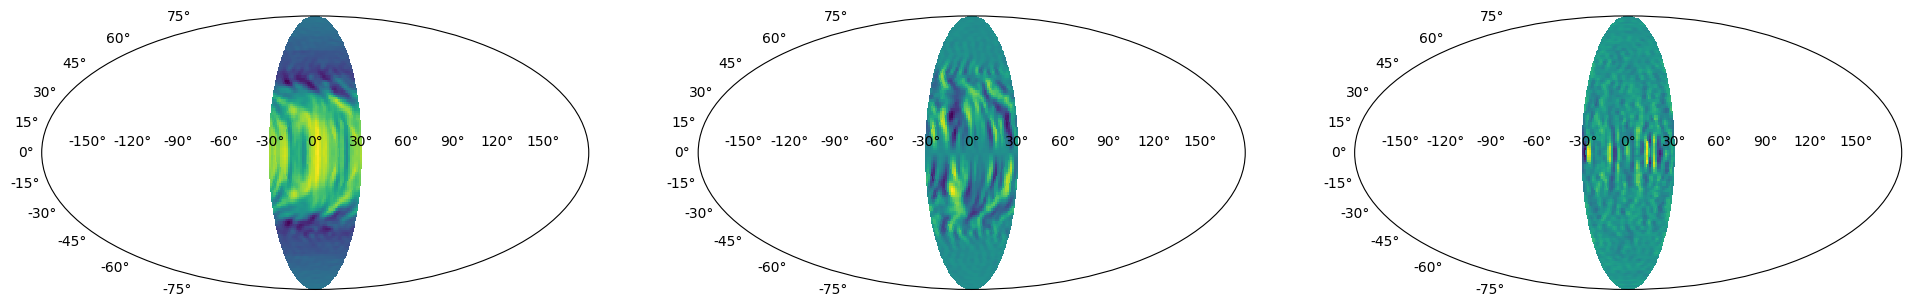

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(24,16),subplot_kw={'projection':'mollweide'})
axes[0].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vphi_outer,shading='auto')
axes[1].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vtheta_outer,shading='auto')
axes[2].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vr_outer,shading='auto')

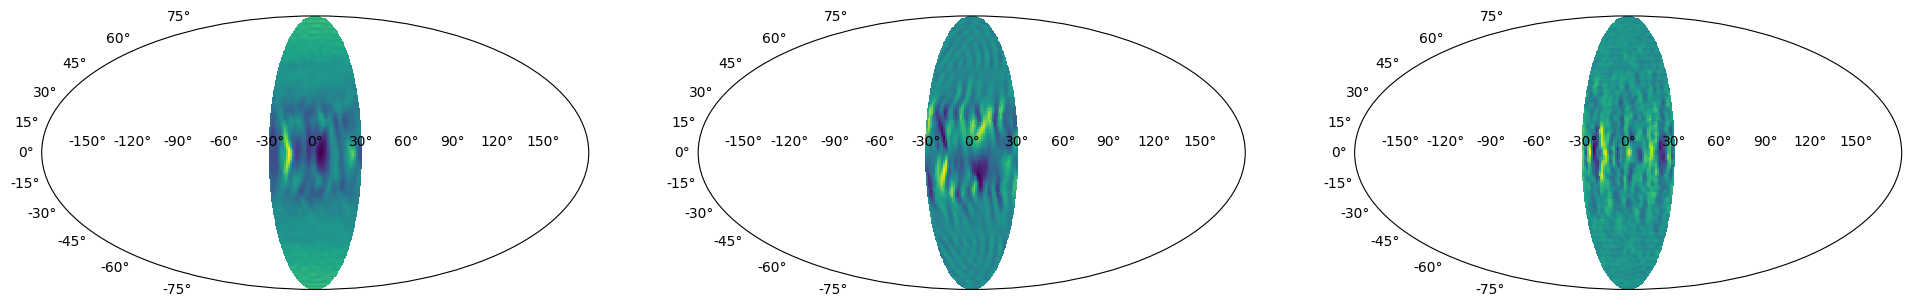

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(24,16),subplot_kw={'projection':'mollweide'})
axes[0].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vphi_inner,shading='auto')
axes[1].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vtheta_inner,shading='auto')
axes[2].pcolormesh(theta_grid-np.pi/6,phi_grid-np.pi/2,vr_inner,shading='auto')

In [ ]:
print(theta_grid)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.0222808  0.0222808  0.0222808  ... 0.0222808  0.0222808  0.0222808 ]
 [0.0445616  0.0445616  0.0445616  ... 0.0445616  0.0445616  0.0445616 ]
 ...
 [1.00263595 1.00263595 1.00263595 ... 1.00263595 1.00263595 1.00263595]
 [1.02491675 1.02491675 1.02491675 ... 1.02491675 1.02491675 1.02491675]
 [1.04719755 1.04719755 1.04719755 ... 1.04719755 1.04719755 1.04719755]]


In [ ]:
print(phi_grid)

[[0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]
 [0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]
 [0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]
 ...
 [0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]
 [0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]
 [0.         0.02196918 0.04393836 ... 3.09765429 3.11962347 3.14159265]]


In [ ]:
vphi_outer,vtheta_outer,vr_outer=np.tile(vphi_outer,(minc,1)),np.tile(vtheta_outer,(minc,1)),np.tile(vr_outer,(minc,1))

In [ ]:
lon=np.linspace(0,2*np.pi,nlon*minc)
lat=np.linspace(0,np.pi,nlat)
theta_grid,phi_grid=np.meshgrid(lon,lat,indexing='ij')

(288, 144) (288, 144) (288, 144)


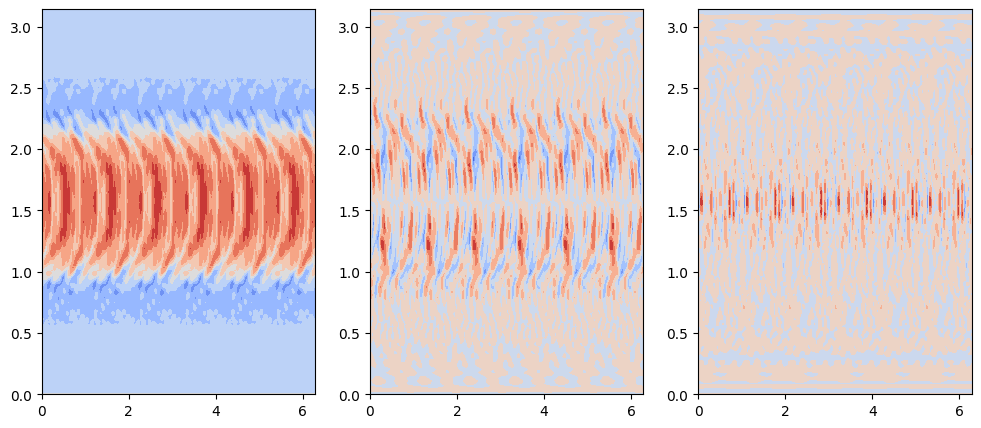

In [ ]:
print(theta_grid.shape,phi_grid.shape,vphi_outer.shape)
fig,axes=plt.subplots(1,3,figsize=(12,5))
axes[0].contourf(theta_grid,phi_grid,vphi_outer,cmap='coolwarm')
axes[1].contourf(theta_grid,phi_grid,vtheta_outer,cmap='coolwarm')
axes[2].contourf(theta_grid,phi_grid,vr_outer,cmap='coolwarm')

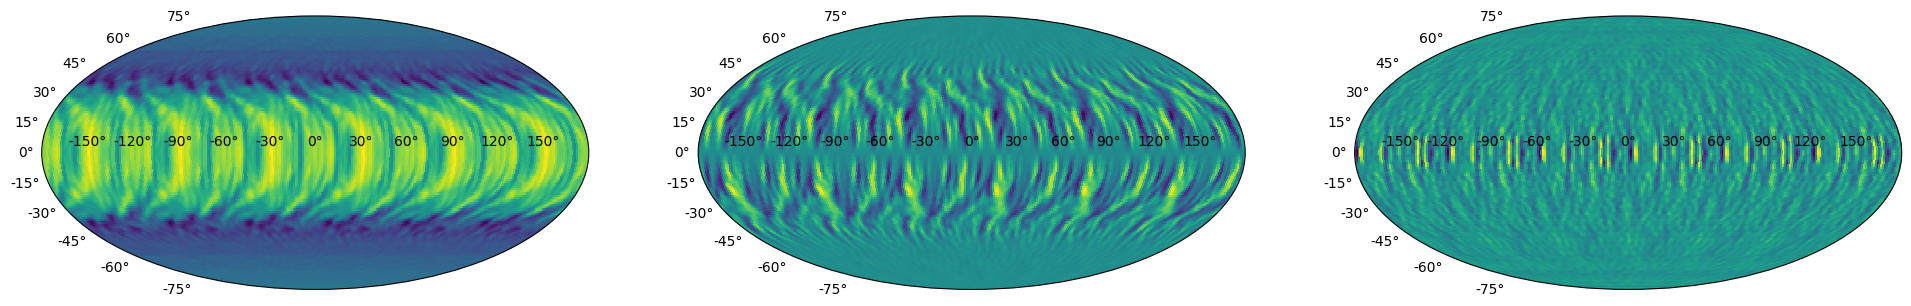

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(24,16),subplot_kw={'projection':'mollweide'})
axes[0].pcolormesh(theta_grid-np.pi,phi_grid-np.pi/2,vphi_outer,shading='auto')
axes[1].pcolormesh(theta_grid-np.pi,phi_grid-np.pi/2,vtheta_outer,shading='auto')
axes[2].pcolormesh(theta_grid-np.pi,phi_grid-np.pi/2,vr_outer,shading='auto')

In [ ]:
vphi_outer,vtheta_outer,vr_outer=vphi_outer.T,vtheta_outer.T,vr_outer.T

In [ ]:
print(vphi_outer.shape,vtheta_outer.shape,vr_outer.shape)

(144, 288) (144, 288) (144, 288)


In [ ]:
vphi_outer,vtheta_outer,vr_outer=vphi_outer.T,vtheta_outer.T,vr_outer.T

In [ ]:
lon=np.linspace(0,2*np.pi,nlon*minc)
lat=np.linspace(0,np.pi,nlat)
phi_grid,theta_grid=np.meshgrid(lon,lat,indexing='ij')

In [ ]:
print(phi_grid.shape,theta_grid.shape)

(288, 144) (288, 144)


In [ ]:
print(vphi_outer.shape,vtheta_outer.shape,vr_outer.shape)

(288, 144) (288, 144) (288, 144)


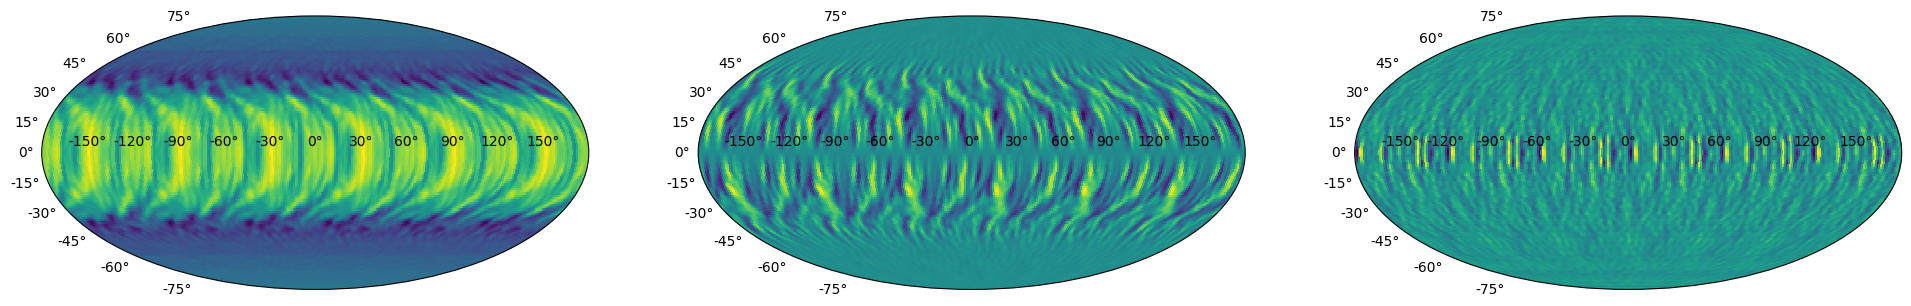

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(24,16),subplot_kw={'projection':'mollweide'})
axes[0].pcolormesh(phi_grid-np.pi,theta_grid-np.pi/2,vphi_outer,shading='auto')
axes[1].pcolormesh(phi_grid-np.pi,theta_grid-np.pi/2,vtheta_outer,shading='auto')
axes[2].pcolormesh(phi_grid-np.pi,theta_grid-np.pi/2,vr_outer,shading='auto')